In [1]:

import pandas as pd

# Load the CSV file
df = pd.read_csv("labeled_sensor_data.csv")

# Check for missing values in x, y, and z columns
missing_values = df[['x', 'y', 'z']].isnull().sum()

print("Missing values in each column:")
print(missing_values)
duplicate_rows = df[df.duplicated()]

print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print("Duplicate rows (if any):")
print(duplicate_rows)
subject_counts = df.groupby('subject').size().reset_index(name='row_count')
print('Subject counts:',subject_counts)

Missing values in each column:
x    0
y    0
z    0
dtype: int64
Number of duplicate rows: 0
Duplicate rows (if any):
Empty DataFrame
Columns: [directory, subject, timestamp, x, y, z, activity_type]
Index: []
Subject counts:   subject  row_count
0      U1       1869
1      U2       3583
2     U21       2131
3     U22       4363
4      U3      34512
5      U4       4830
6      U5       5188
7      U6      33881
8      U7      12575


In [2]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize x, y, z columns
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [3]:
# Sort by subject, activity_type, and timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', dayfirst=False, errors='coerce').dt.tz_convert('UTC')
df = df.sort_values(['subject', 'activity_type', 'timestamp'])

# Compute time differences within each subject and activity_type group
df['time_diff'] = df.groupby(['subject', 'activity_type'])['timestamp'].diff().dt.total_seconds()

# Assign a new sequence_id when time_diff > 1 second (indicating a gap)
df['sequence_id'] = (df['time_diff'] > 1.0).cumsum()

# Drop time_diff as it’s no longer needed
df = df.drop(columns=['time_diff'])

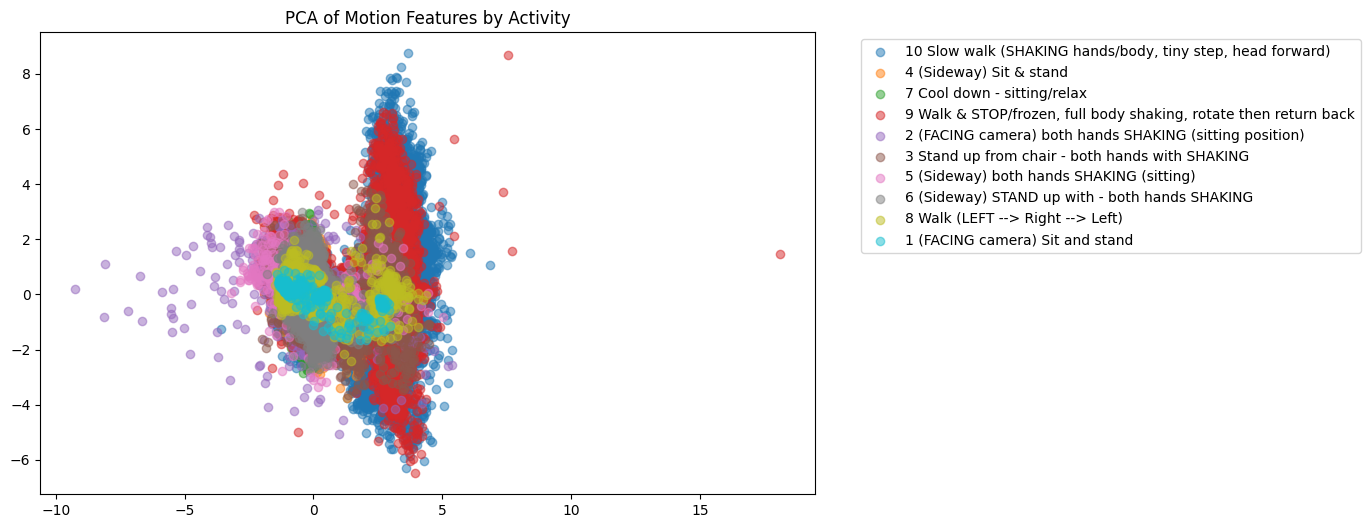

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality
pca = PCA(n_components=2)
df['pca1'], df['pca2'] = zip(*pca.fit_transform(df[['x', 'y', 'z']]).tolist())

# Plot
plt.figure(figsize=(10, 6))
for act in df['activity_type'].unique():
    subset = df[df['activity_type'] == act]
    plt.scatter(subset['pca1'], subset['pca2'], label=act, alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of Motion Features by Activity')
plt.show()


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def generate_windows(group, window_size=pd.Timedelta(seconds=2), step_size=pd.Timedelta(seconds=1)):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            windows.append(window_data)
            labels.append(group['activity_type'].iloc[0])  # All rows have the same activity_type
        current_start += step_size
    
    return windows, labels

# Process all sequences
all_windows = []
all_labels = []
for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    windows, labels = generate_windows(group)
    all_windows.extend(windows)
    all_labels.extend(labels)

In [8]:
def extract_features(window_data):
    features = {}
    
    # Add subject
    features['subject'] = window_data['subject'].iloc[0]
    
    # Time-Domain Features
    for axis in ['x', 'y', 'z']:
        data = window_data[axis]
        features[f'{axis}_mean'] = data.mean()
        features[f'{axis}_std'] = data.std()
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurt'] = kurtosis(data)
    
    # Magnitude Features
    mag = np.sqrt(window_data['x']**2 + window_data['y']**2 + window_data['z']**2)
    features['mag_mean'] = mag.mean()
    features['mag_std'] = mag.std()
    
    # Frequency-Domain Features
    for axis in ['x', 'y', 'z']:
        fft_vals = np.abs(np.fft.fft(window_data[axis]))[:len(window_data[axis])//2]
        freqs = np.fft.fftfreq(len(window_data[axis]), d=0.135)[:len(window_data[axis])//2]
        for low, high in [(0, 1), (1, 2), (2, 3), (3, 3.7)]:
            mask = (freqs >= low) & (freqs < high)
            features[f'{axis}_power_{low}-{high}'] = np.sum(fft_vals[mask]**2) if mask.any() else 0
    
    # Step Frequency
    peaks, _ = find_peaks(mag, height=mag.mean() + mag.std(), distance=3)
    window_duration = (window_data['timestamp'].max() - window_data['timestamp'].min()).total_seconds()
    features['step_frequency'] = len(peaks) / window_duration if window_duration > 0 else 0
    
    return features


# Extract features from all windows
feature_list = [extract_features(window) for window in all_windows]
features_df = pd.DataFrame(feature_list)
features_df['label'] = all_labels

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features_df['label'] = le.fit_transform(features_df['label'])

In [10]:
subjects = features_df['subject'].unique()
train_subjects = subjects[:7]
test_subjects = subjects[7:]

train_df = features_df[features_df['subject'].isin(train_subjects)]
test_df = features_df[features_df['subject'].isin(test_subjects)]


X_train = train_df.drop(columns=['label', 'subject'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label', 'subject'])
y_test = test_df['label']

In [11]:
train_df.subject.value_counts(),train_subjects,test_subjects

(subject
 U3     700
 U22    526
 U4     526
 U5     524
 U2     406
 U21    234
 U1     232
 Name: count, dtype: int64,
 array(['U1', 'U2', 'U21', 'U22', 'U3', 'U4', 'U5'], dtype=object),
 array(['U6', 'U7'], dtype=object))

In [12]:
train_df

,subject,x_mean,x_std,x_skew,x_kurt,y_mean,y_std,y_skew,y_kurt,z_mean,...,y_power_0-1,y_power_1-2,y_power_2-3,y_power_3-3.7,z_power_0-1,z_power_1-2,z_power_2-3,z_power_3-3.7,step_frequency,label
0,U1,1.039046,0.289536,0.636500,0.186002,-2.825303,0.237446,0.851809,0.515705,-1.090639,...,1799.461384,1.752469,0.680077,0.000000,268.867212,0.738078,0.080534,0.000000,0.537057,1
1,U1,1.051399,0.191080,0.299686,3.119047,-2.291205,0.406181,-0.338864,-0.093433,-0.422957,...,5432.738400,15.490807,6.251968,2.869321,264.598168,9.064423,2.368158,0.617669,1.033592,1
2,U1,0.799902,0.335252,-0.543869,-0.810680,-1.711159,0.658912,0.085218,-0.768201,0.032903,...,5482.616175,35.517607,14.231575,5.963741,157.065633,12.131387,0.752298,1.190038,1.125492,1
3,U1,0.275722,0.324626,-0.052842,-1.212538,-0.826562,0.409405,-0.209649,-1.130426,0.447884,...,466.856616,7.286460,1.606632,1.024365,128.380347,1.003185,0.429495,0.145687,0.000000,1
4,U1,-0.082938,0.079295,-0.767694,0.276705,-0.303571,0.135254,-0.368033,-1.185725,0.425295,...,25.377995,0.326606,0.069823,0.002830,46.449367,0.140392,0.124444,0.040101,0.502513,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,U5,1.462804,0.268560,-0.534577,0.062305,-2.409635,0.233372,-0.272897,-1.113606,-1.242487,...,1306.573206,2.107369,3.329799,0.000000,349.140513,10.333474,21.908799,0.000000,0.535906,9
3144,U5,1.375083,0.263124,-0.143905,-0.583934,-2.501703,0.246965,-0.200440,-1.124669,-1.359655,...,1410.122101,1.416509,2.966668,0.000000,419.805877,7.906470,33.647142,0.000000,1.072961,9
3145,U5,1.267863,0.166759,0.258197,-0.806400,-2.565037,0.227897,0.283226,-0.845142,-1.484697,...,1481.962707,1.296445,2.091998,0.000000,497.770922,15.040278,17.268311,0.000000,0.537057,9
3146,U5,1.311921,0.352903,0.310465,-0.634592,-2.530640,0.279415,0.054591,-1.291133,-1.275789,...,1442.409683,1.388280,2.810917,0.000000,370.085582,1.515792,7.442286,0.000000,1.072386,9


In [13]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Optional: combine your X_train, y_train for splitting inside Optuna if needed
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Create model with sampled parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Use weighted F1 score to account for class imbalance
    score = f1_score(y_test, y_pred, average='weighted')
    return score

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=300)  # e.g., 50 trials or 5 mins max

# Print best result
print("Best trial:")
print("  Value (F1):", study.best_trial.value)
print("  Params:", study.best_trial.params)

# Use best parameters to retrain model
best_params = study.best_trial.params
optimized_model = RandomForestClassifier(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)

# Final evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))



c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-22 06:38:08,536] A new study created in memory with name: no-name-d823dc4d-41b5-42de-a447-fb355ef69737
[I 2025-05-22 06:38:08,782] Trial 0 finished with value: 0.1617683106875299 and parameters: {'n_estimators': 80, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1617683106875299.
[I 2025-05-22 06:38:09,084] Trial 1 finished with value: 0.1685317194381897 and parameters: {'n_estimators': 31, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 1 with value: 0.1685317194381897.
[I 2025-05-22 06:38:09,167] Trial 2 finished with value: 0.15068295888704214 and parameters: {'n_estimators'

Best trial:
  Value (F1): 0.1849853811231795
  Params: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}
              precision    recall  f1-score   support

           1       0.30      0.45      0.36       176
           2       0.18      0.12      0.15        58
           3       0.16      0.11      0.13       116
           4       0.01      0.02      0.02        58
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00       116
           7       0.00      0.00      0.00        58
           8       0.11      0.16      0.13        58
           9       0.27      0.29      0.28       236

    accuracy                           0.20       876
   macro avg       0.12      0.13      0.12       876
weighted avg       0.18      0.20      0.18       876



c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

### Advanced Approach: Subject-Adaptive Transformer with Domain-Specific Features

In [29]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing: Normalize per subject
def normalize_per_subject(df):
    scaler = StandardScaler()
    for subject in df['subject'].unique():
        mask = df['subject'] == subject
        df.loc[mask, ['x', 'y', 'z']] = scaler.fit_transform(df.loc[mask, ['x', 'y', 'z']])
    return df

# Data Augmentation: Add jitter
def augment_data(window_data):
    noise = np.random.normal(0, 0.01, window_data[['x', 'y', 'z']].shape)
    window_data[['x', 'y', 'z']] += noise
    return window_data

# Generate Windows
def generate_windows(group, window_size=pd.Timedelta(seconds=1), step_size=pd.Timedelta(seconds=0.5)):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    subjects = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            # Apply augmentation with 50% probability
            if np.random.rand() > 0.5:
                window_data = augment_data(window_data.copy())
            windows.append(window_data)
            labels.append(group['activity_type'].iloc[0])
            subjects.append(group['subject'].iloc[0])
        current_start += step_size
    
    return windows, labels, subjects

# Feature Extraction
def extract_features(window_data):
    features = {}
    
    # Time-Domain Features
    for axis in ['x', 'y', 'z']:
        data = window_data[axis]
        features[f'{axis}_mean'] = data.mean()
        features[f'{axis}_std'] = data.std()
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurt'] = kurtosis(data)
        features[f'{axis}_min'] = data.min()
        features[f'{axis}_max'] = data.max()
        features[f'{axis}_range'] = data.max() - data.min()
    
    # Magnitude Features
    mag = np.sqrt(window_data['x']**2 + window_data['y']**2 + window_data['z']**2)
    features['mag_mean'] = mag.mean()
    features['mag_std'] = mag.std()
    
    # Cross-Axis Correlation
    features['xy_corr'] = window_data['x'].corr(window_data['y'])
    features['xz_corr'] = window_data['x'].corr(window_data['z'])
    features['yz_corr'] = window_data['y'].corr(window_data['z'])
    
    # Frequency-Domain Features
    for axis in ['x', 'y', 'z']:
        fft_vals = np.abs(np.fft.fft(window_data[axis]))[:len(window_data[axis])//2]
        freqs = np.fft.fftfreq(len(window_data[axis]), d=0.135)[:len(window_data[axis])//2]
        for low, high in [(0, 1), (1, 2), (2, 3), (3, 3.7)]:
            mask = (freqs >= low) & (freqs < high)
            features[f'{axis}_power_{low}-{high}'] = np.sum(fft_vals[mask]**2) if mask.any() else 0
    
    # Step Frequency
    peaks, _ = find_peaks(mag, height=mag.mean() + mag.std(), distance=3)
    window_duration = (window_data['timestamp'].max() - window_data['timestamp'].min()).total_seconds()
    features['step_frequency'] = len(peaks) / window_duration if window_duration > 0 else 0
    
    # Convert to numerical array
    feature_values = [v if not np.isnan(v) else 0 for k, v in features.items()]
    return np.array(feature_values)

# Prepare Sequences
def prepare_sequences(df, max_seq_len=50):
    sequences = []
    labels = []
    subjects = []
    max_len = 0
    for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
        windows, window_labels, window_subjects = generate_windows(group)
        if windows:
            sequence_features = [extract_features(window) for window in windows]
            seq_len = len(sequence_features)
            if seq_len > max_seq_len:
                sequence_features = sequence_features[:max_seq_len]
                seq_len = max_seq_len
            max_len = max(max_len, seq_len)
            sequences.append(np.array(sequence_features))
            labels.append(window_labels[0])
            subjects.append(window_subjects[0])
    print(f"Maximum sequence length: {max_len}")
    return sequences, labels, subjects, max_len

# Custom Dataset
class ActivityDataset(Dataset):
    def __init__(self, sequences, labels, subjects, subject_encoder):
        self.sequences = sequences
        self.labels = labels
        self.subjects = [subject_encoder.get(subj, len(subject_encoder)) for subj in subjects]
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.subjects[idx]

def collate_fn(batch):
    sequences, labels, subjects = zip(*batch)
    max_len = max(seq.shape[0] for seq in sequences)
    padded_sequences = []
    masks = []
    for seq in sequences:
        pad_width = ((0, max_len - seq.shape[0]), (0, 0))
        padded_seq = np.pad(seq, pad_width, mode='constant', constant_values=0)
        padded_sequences.append(padded_seq)
        mask = np.ones(seq.shape[0], dtype=bool)
        mask = np.pad(mask, (0, max_len - seq.shape[0]), mode='constant', constant_values=False)
        masks.append(mask)
    return (torch.tensor(padded_sequences, dtype=torch.float32),
            torch.tensor(masks, dtype=torch.bool),
            torch.tensor(labels, dtype=torch.long),
            torch.tensor(subjects, dtype=torch.long))

# Transformer Model
class ActivityTransformer(nn.Module):
    def __init__(self, num_features, num_classes, num_subjects, max_seq_len, d_model=64, num_heads=4, num_layers=1, dropout=0.3, embedding_dim=16):
        super(ActivityTransformer, self).__init__()
        self.d_model = d_model
        self.subject_embedding = nn.Embedding(num_subjects + 1, embedding_dim)
        self.input_proj = nn.Linear(num_features + embedding_dim, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_seq_len + 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward=256, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x, mask, subject_ids):
        batch_size, seq_len, num_features = x.shape
        subj_emb = self.subject_embedding(subject_ids).unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat((x, subj_emb), dim=-1)
        x = self.input_proj(x)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        pos_encoding = self.pos_encoder[:, :seq_len + 1, :]
        x += pos_encoding
        cls_mask = torch.ones(batch_size, 1, dtype=torch.bool, device=x.device)
        full_mask = torch.cat((cls_mask, mask), dim=1)
        transformer_mask = ~full_mask
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        x = x.permute(1, 0, 2)
        cls_output = x[:, 0, :]
        return self.classifier(cls_output)

# Training and Evaluation Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        sequences, masks, labels, subjects = [b.to(device) for b in batch]
        optimizer.zero_grad()
        logits = model(sequences, masks, subjects)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, le):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            sequences, masks, labels, subjects = [b.to(device) for b in batch]
            logits = model(sequences, masks, subjects)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    # Per-class F1
    per_class_f1 = f1_score(true, preds, average=None)
    print("Per-class F1-scores:", dict(zip(le.classes_, per_class_f1)))
    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    return acc, f1

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
    
    def __call__(self, val_f1, model):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


# Preprocess
df = normalize_per_subject(df)
sequences, labels, subjects, max_seq_len = prepare_sequences(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}

val_subjects = ['U3','U7']  
train_idx = [i for i, s in enumerate(subjects) if s not in val_subjects]
val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]

train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])

train_dataset = ActivityDataset(*train_data, subject_encoder)
val_dataset = ActivityDataset(*val_data, subject_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


# Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = sequences[0].shape[1]  # Should be 24: (7 time + 4 freq) * 3 axes + 2 mag + 3 corr + 1 step
model = ActivityTransformer(
    num_features=num_features,
    num_classes=len(le.classes_),
    num_subjects=len(subject_encoder),
    max_seq_len=max_seq_len,
    d_model=64,
    num_heads=4,
    num_layers=1,
    dropout=0.3,
    embedding_dim=16
).to(device)
class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
early_stopping = EarlyStopping(patience=5)

# Training Loop
for epoch in range(30):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = evaluate(model, val_loader, device, le)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
    scheduler.step(train_loss)
    # early_stopping(val_f1, model)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered")
    #     break

Maximum sequence length: 50
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 1: Loss=2.5185, Val Acc=0.0714, Val F1=0.0476
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 2: Loss=2.3080, Val Acc=0.1429, Val F1=0.0833
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 3: Loss=2.3100, Val Acc=0.1429, Val F1=0.1143
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 4: Loss=2.1831, Val Acc=0.1429, Val F1=0.1429
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 5: Loss=2.2121, Val Acc=0.0714, Val F1=0.0952
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 6: Loss=2.1275, Val Acc=0.2143, Val F1=0.1714
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 7: Loss=1.9099, Val Acc=0.2143, Val F1=0.1619
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 8: Loss=2.0607, Val Acc=0.1429, Val F1=0.0918
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 9: Loss=1.8926, Val Acc=0.1429, Val F1=0.0893
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 10: Loss=1.8617, Val Acc=0.2143, Val F1=0.1369
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 11: Loss=1.8273, Val Acc=0.2143, Val F1=0.1369
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 12: Loss=1.9374, Val Acc=0.2143, Val F1=0.1369
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 13: Loss=1.7899, Val Acc=0.2143, Val F1=0.1369
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 14: Loss=1.7410, Val Acc=0.2143, Val F1=0.1571
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 15: Loss=1.6443, Val Acc=0.1429, Val F1=0.0643
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 16: Loss=1.6072, Val Acc=0.1429, Val F1=0.0643
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 17: Loss=1.5237, Val Acc=0.1429, Val F1=0.0561
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 18: Loss=1.6024, Val Acc=0.1429, Val F1=0.0595
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 19: Loss=1.5641, Val Acc=0.1429, Val F1=0.0714
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 20: Loss=1.4604, Val Acc=0.1429, Val F1=0.0714
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 21: Loss=1.3577, Val Acc=0.1429, Val F1=0.0643
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 22: Loss=1.4312, Val Acc=0.1429, Val F1=0.0643
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 23: Loss=1.3144, Val Acc=0.2143, Val F1=0.1286
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 24: Loss=1.3448, Val Acc=0.2143, Val F1=0.1286
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 25: Loss=1.2907, Val Acc=0.2143, Val F1=0.1214
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 26: Loss=1.1705, Val Acc=0.2143, Val F1=0.1786
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 27: Loss=1.2500, Val Acc=0.1429, Val F1=0.1071
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 28: Loss=1.0556, Val Acc=0.1429, Val F1=0.0833
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 29: Loss=1.1536, Val Acc=0.2143, Val F1=0.1286
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.8, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 30: Loss=1.0644, Val Acc=0.2857, Val F1=0.1857


In [ ]:
best_f1 = 0
best_epoch = 0
best_model_state = None  # to optionally save best model
val_subjects = ['U5']  
train_idx = [i for i, s in enumerate(subjects) if s not in val_subjects]
val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]

train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])

train_dataset = ActivityDataset(*train_data, subject_encoder)
val_dataset = ActivityDataset(*val_data, subject_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

for epoch in range(40):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = evaluate(model, val_loader, device, le)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch + 1
        best_model_state = model.state_dict()  # save model state

    scheduler.step(train_loss)
    # Optional early stopping
    # early_stopping(val_f1, model)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered")
    #     break

print(f"\nBest Epoch: {best_epoch} with F1-score: {best_f1:.4f}")


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}
Epoch 1: Loss=1.8784, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 2: Loss=1.1876, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 3: Loss=1.3455, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 4: Loss=1.6384, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 5: Loss=1.5645, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 6: Loss=1.5185, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 7: Loss=1.4242, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 8: Loss=1.6757, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 9: Loss=1.3798, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 10: Loss=1.1325, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 11: Loss=2.0293, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 12: Loss=1.8613, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 13: Loss=1.3911, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 14: Loss=1.7122, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 15: Loss=1.2307, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 16: Loss=1.3134, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 17: Loss=1.5210, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 18: Loss=1.2266, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 19: Loss=1.1712, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 20: Loss=1.3852, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 21: Loss=1.3346, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 22: Loss=1.3240, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 23: Loss=1.5309, Val Acc=1.0000, Val F1=1.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\479751633.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


In [ ]:
# torch.save(best_model_state, 'best_model_85.pt')


In [ ]:
# # Save the trained model
# torch.save(model.state_dict(), 'activity_transformer_model.pth')
# print("Model saved to 'activity_transformer_model.pth'")
# # Make sure the model architecture matches exactly
# model = ActivityTransformer(
#     num_features=num_features,
#     num_classes=len(le.classes_),
#     num_subjects=len(subject_encoder),
#     max_seq_len=max_seq_len,
#     d_model=64,
#     num_heads=4,
#     num_layers=1,
#     dropout=0.3,
#     embedding_dim=16
# ).to(device)

# # Load weights
# model.load_state_dict(torch.load('activity_transformer_model.pth'))
# model.eval()  # Set to evaluation mode for inference
# print("Model loaded and ready for inference.")


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import itertools

# Assume df is already loaded and contains the data
# List of all subjects (assuming 'U1' to 'U9')
all_subjects = ['U1', 'U2', 'U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'U9']

# Objective function for Optuna
def objective(trial):
    # Suggest two subjects for validation
    val_subject_1 = trial.suggest_categorical('val_subject_1', all_subjects)
    remaining_subjects = [s for s in all_subjects if s != val_subject_1]
    val_subject_2 = trial.suggest_categorical('val_subject_2', remaining_subjects)
    val_subjects = [val_subject_1, val_subject_2]
    train_subjects = [s for s in all_subjects if s not in val_subjects]
    
    # Preprocess
    df_normalized = normalize_per_subject(df)
    sequences, labels, subjects, max_seq_len = prepare_sequences(df_normalized)
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}
    
    # Split data
    train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
    val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
    
    train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
    val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
    
    train_dataset = ActivityDataset(*train_data, subject_encoder)
    val_dataset = ActivityDataset(*val_data, subject_encoder)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    
    # Model Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_features = sequences[0].shape[1]
    model = ActivityTransformer(
        num_features=num_features,
        num_classes=len(le.classes_),
        num_subjects=len(subject_encoder),
        max_seq_len=max_seq_len,
        d_model=64,
        num_heads=4,
        num_layers=1,
        dropout=0.3,
        embedding_dim=16
    ).to(device)
    class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopping = EarlyStopping(patience=5)
    
    # Training Loop
    best_val_acc = 0
    for epoch in range(30):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_acc, val_f1 = evaluate(model, val_loader, device, le)
        print(f"Trial {trial.number}, Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
        scheduler.step(train_loss)
        early_stopping(val_f1, model)
        best_val_acc = max(best_val_acc, val_acc)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break
    
    # Save confusion matrix for this trial
    # plt.figure(figsize=(10, 8))
    # cm = confusion_matrix(labels_encoded[val_idx], model(val_loader.dataset.sequences, val_loader.dataset.masks, val_loader.dataset.subjects).argmax(dim=1).cpu().numpy())
    # sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.savefig(f'confusion_matrix_trial_{trial.number}.png')
    # plt.close()
    
    # return best_val_acc

# Create Optuna study
study = optuna.create_study(direction='maximize')
# Generate all possible combinations of 2 subjects
combinations = list(itertools.combinations(all_subjects, 2))
for val_subjects in combinations:
    study.enqueue_trial({
        'val_subject_1': val_subjects[0],
        'val_subject_2': val_subjects[1]
    })

# Run the optimization
study.optimize(objective, n_trials=len(combinations))

# Print results
best_trial = study.best_trial
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print(f"Best Validation Subjects: {best_trial.params['val_subject_1']}, {best_trial.params['val_subject_2']}")
print(f"Training Subjects: {[s for s in all_subjects if s not in [best_trial.params['val_subject_1'], best_trial.params['val_subject_2']]]}")

### CNN


In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import torch.optim as optim

# Assuming df is loaded with columns: 'subject', 'activity_type', 'sequence_id', 'timestamp', 'x', 'y', 'z'

# Generate windows of raw accelerometer data
def generate_windows(group, window_size=pd.Timedelta(seconds=2), step_size=pd.Timedelta(seconds=1), fixed_samples=15):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    subjects = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            raw_window = window_data[['x', 'y', 'z']].values
            if len(raw_window) < fixed_samples:
                pad_width = ((0, fixed_samples - len(raw_window)), (0, 0))
                raw_window = np.pad(raw_window, pad_width, mode='constant', constant_values=0)
            elif len(raw_window) > fixed_samples:
                raw_window = raw_window[:fixed_samples]
            windows.append(raw_window)
            labels.append(group['activity_type'].iloc[0])
            subjects.append(group['subject'].iloc[0])
        current_start += step_size
    
    return windows, labels, subjects

# Collect all windows, labels, and subjects
all_windows = []
all_labels = []
all_subjects = []
for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    windows, labels, subjects = generate_windows(group)
    all_windows.extend(windows)
    all_labels.extend(labels)
    all_subjects.extend(subjects)

# Encode activity labels
le = LabelEncoder()
all_labels_encoded = le.fit_transform(all_labels)

# Split data for leave-one-subject-out validation (example: validate on 'U3')
val_subject = 'U3'
train_idx = [i for i, s in enumerate(all_subjects) if s != val_subject]
val_idx = [i for i, s in enumerate(all_subjects) if s == val_subject]

train_windows = [all_windows[i] for i in train_idx]
train_labels = [all_labels_encoded[i] for i in train_idx]
val_windows = [all_windows[i] for i in val_idx]
val_labels = [all_labels_encoded[i] for i in val_idx]

# Define custom Dataset class
class WindowDataset(Dataset):
    def __init__(self, windows, labels, subjects):
        self.windows = windows
        self.labels = labels
        self.subjects = subjects
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = torch.tensor(self.windows[idx], dtype=torch.float32).transpose(0, 1)  # Shape: (3, 15)
        label = self.labels[idx]
        subject = self.subjects[idx]
        return window, label, subject

# Create DataLoaders
train_dataset = WindowDataset(train_windows, train_labels, [all_subjects[i] for i in train_idx])
val_dataset = WindowDataset(val_windows, val_labels, [all_subjects[i] for i in val_idx])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define CNN model
class ActivityCNN(nn.Module):
    def __init__(self, num_classes):
        super(ActivityCNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3)  # Input channels: 3 (x, y, z)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 2, 128)  # Adjust based on output size after conv/pool
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ActivityCNN(num_classes=len(le.classes_)).to(device)

# Compute class weights for imbalance
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts[i] for i in range(len(le.classes_))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        windows, labels, _ = batch
        windows = windows.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(windows)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            windows, labels, _ = batch
            windows = windows.to(device)
            labels = labels.to(device)

            logits = model(windows)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    return acc, f1


# Training loop
for epoch in range(50):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

Epoch 1: Loss=2.2019, Val Acc=0.1129, Val F1=0.1165
Epoch 2: Loss=2.1065, Val Acc=0.1214, Val F1=0.1177
Epoch 3: Loss=2.0469, Val Acc=0.1100, Val F1=0.1052
Epoch 4: Loss=1.9812, Val Acc=0.0714, Val F1=0.0895
Epoch 5: Loss=1.9184, Val Acc=0.0814, Val F1=0.0652
Epoch 6: Loss=1.8631, Val Acc=0.1171, Val F1=0.0790
Epoch 7: Loss=1.8320, Val Acc=0.1086, Val F1=0.0742
Epoch 8: Loss=1.7958, Val Acc=0.1257, Val F1=0.1116
Epoch 9: Loss=1.7548, Val Acc=0.1171, Val F1=0.1105
Epoch 10: Loss=1.7226, Val Acc=0.1071, Val F1=0.0840
Epoch 11: Loss=1.6841, Val Acc=0.1557, Val F1=0.1311
Epoch 12: Loss=1.6594, Val Acc=0.0900, Val F1=0.0809
Epoch 13: Loss=1.6500, Val Acc=0.1114, Val F1=0.0937
Epoch 14: Loss=1.5966, Val Acc=0.1043, Val F1=0.0845
Epoch 15: Loss=1.5681, Val Acc=0.1100, Val F1=0.1079
Epoch 16: Loss=1.5655, Val Acc=0.1029, Val F1=0.0980
Epoch 17: Loss=1.5144, Val Acc=0.1100, Val F1=0.1110
Epoch 18: Loss=1.4868, Val Acc=0.1214, Val F1=0.1219
Epoch 19: Loss=1.4710, Val Acc=0.1571, Val F1=0.1614
Ep

In [28]:
import optuna
from torch.utils.data import DataLoader


def objective(trial):
    # Hyperparameter search space
    conv1_channels = trial.suggest_categorical("conv1_channels", [16, 32, 64])
    conv2_channels = trial.suggest_categorical("conv2_channels", [32, 64, 128])
    fc1_units = trial.suggest_categorical("fc1_units", [64, 128, 256])
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # Dataset & loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model definition inside trial
    class TrialActivityCNN(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.conv1 = nn.Conv1d(3, conv1_channels, kernel_size=3)
            self.pool1 = nn.MaxPool1d(2)
            self.conv2 = nn.Conv1d(conv1_channels, conv2_channels, kernel_size=3)
            self.pool2 = nn.MaxPool1d(2)
            conv_output_size = 15  # initial length
            conv_output_size = (conv_output_size - 2) // 2  # after conv1 + pool1
            conv_output_size = (conv_output_size - 2) // 2  # after conv2 + pool2
            self.fc1 = nn.Linear(conv2_channels * conv_output_size, fc1_units)
            self.fc2 = nn.Linear(fc1_units, len(le.classes_))

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrialActivityCNN(num_classes=len(le.classes_)).to(device)

    # Weighted loss
    class_counts = Counter(train_labels)
    class_weights = [1.0 / class_counts[i] for i in range(len(le.classes_))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Training loop (short for speed)
    for epoch in range(10):
        model.train()
        for windows, labels, _ in train_loader:
            windows, labels = windows.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(windows)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for windows, labels, _ in val_loader:
            windows, labels = windows.to(device), labels.to(device)
            outputs = model(windows)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    return f1_score(true, preds, average='weighted')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)  # Try 30 trials or 10 mins

print("Best trial:")
print("  Value (F1):", study.best_trial.value)
print("  Params:", study.best_trial.params)


[I 2025-05-22 07:08:04,538] A new study created in memory with name: no-name-3f8b5eb1-2092-44fa-aa58-36ae53030b05
C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\709362774.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-05-22 07:08:05,512] Trial 0 finished with value: 0.0847892647347964 and parameters: {'conv1_channels': 32, 'conv2_channels': 128, 'fc1_units': 256, 'lr': 0.0014794848389776975, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.0847892647347964.
C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\709362774.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learn

Best trial:
  Value (F1): 0.19530890652970548
  Params: {'conv1_channels': 16, 'conv2_channels': 128, 'fc1_units': 64, 'lr': 0.0008922842906368305, 'batch_size': 64, 'optimizer': 'SGD'}


### LSTM

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import torch.optim as optim

# Assuming df is a DataFrame with columns: 'subject', 'activity_type', 'sequence_id', 'timestamp', 'x', 'y', 'z'

# Prepare sequences from raw data
sequences = []
labels = []
subjects = []
max_seq_len = 300  # Maximum sequence length; adjust based on data

for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    seq = group[['x', 'y', 'z']].values  # Raw accelerometer data
    if len(seq) > max_seq_len:
        seq = seq[:max_seq_len]  # Truncate long sequences
    sequences.append(seq)
    labels.append(activity_type)
    subjects.append(subject)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Subject-based train-test split
unique_subjects = np.unique(subjects)
train_subjects = unique_subjects[:7]
test_subjects = unique_subjects[7:]
print(f"Training subjects: {train_subjects}")
print(f"Testing subjects: {test_subjects}")

train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
test_idx = [i for i, s in enumerate(subjects) if s in test_subjects]

train_sequences = [sequences[i] for i in train_idx]
train_labels = [labels_encoded[i] for i in train_idx]
train_subjects_list = [subjects[i] for i in train_idx]
test_sequences = [sequences[i] for i in test_idx]
test_labels = [labels_encoded[i] for i in test_idx]
test_subjects_list = [subjects[i] for i in test_idx]

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, subjects):
        self.sequences = sequences
        self.labels = labels
        self.subjects = subjects
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.subjects[idx]

# Collate function to pad sequences
def collate_fn(batch):
    sequences, labels, subjects = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)
    padded_sequences = []
    for seq in sequences:
        pad_width = ((0, max_len - len(seq)), (0, 0))
        padded_seq = np.pad(seq, pad_width, mode='constant', constant_values=0)
        padded_sequences.append(padded_seq)
    return (torch.tensor(padded_sequences, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.long),
            torch.tensor(lengths, dtype=torch.long),
            subjects)

# LSTM Model
class ActivityLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1, num_classes=10, bidirectional=False):
        super(ActivityLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)
    
    def forward(self, x, lengths):
        lstm_out, _ = self.lstm(x)
        batch_size = x.size(0)
        indices = torch.arange(batch_size, device=x.device)
        last_outputs = lstm_out[indices, lengths - 1, :]  # Last non-padded output
        logits = self.fc(last_outputs)
        return logits

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
    
    def __call__(self, test_f1, model):
        score = test_f1
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ActivityLSTM(num_classes=len(le.classes_)).to(device)

# Class weights
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts.get(i, 1) for i in range(len(le.classes_))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.00015858980930332859)

# DataLoaders
train_dataset = SequenceDataset(train_sequences, train_labels, train_subjects_list)
test_dataset = SequenceDataset(test_sequences, test_labels, test_subjects_list)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Training and Evaluation
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        padded_sequences, labels, lengths, _ = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
        optimizer.zero_grad()
        logits = model(padded_sequences, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            padded_sequences, labels, lengths, _ = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
            logits = model(padded_sequences, lengths)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    return acc, f1

# Training Loop
early_stopping = EarlyStopping(patience=5)
for epoch in range(30):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_acc, test_f1 = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Test Acc={test_acc:.4f}, Test F1={test_f1:.4f}")
    early_stopping(test_f1, model)
    

Training subjects: ['U1' 'U2' 'U21' 'U22' 'U3' 'U4' 'U5']
Testing subjects: ['U6' 'U7']
Epoch 1: Loss=2.3178, Test Acc=0.1667, Test F1=0.0513
Epoch 2: Loss=2.3092, Test Acc=0.1667, Test F1=0.0513
Epoch 3: Loss=2.3045, Test Acc=0.1667, Test F1=0.0513
Epoch 4: Loss=2.3052, Test Acc=0.1667, Test F1=0.0513
Epoch 5: Loss=2.2970, Test Acc=0.1667, Test F1=0.0513
Epoch 6: Loss=2.3002, Test Acc=0.1667, Test F1=0.0513
Epoch 7: Loss=2.3008, Test Acc=0.1667, Test F1=0.0513
Epoch 8: Loss=2.2745, Test Acc=0.1667, Test F1=0.0513
Epoch 9: Loss=2.3153, Test Acc=0.1667, Test F1=0.0513
Epoch 10: Loss=2.3043, Test Acc=0.1667, Test F1=0.0513
Epoch 11: Loss=2.2995, Test Acc=0.1667, Test F1=0.0513
Epoch 12: Loss=2.2821, Test Acc=0.1667, Test F1=0.0513
Epoch 13: Loss=2.2926, Test Acc=0.1667, Test F1=0.0513
Epoch 14: Loss=2.2979, Test Acc=0.1667, Test F1=0.0513
Epoch 15: Loss=2.2944, Test Acc=0.1667, Test F1=0.0513
Epoch 16: Loss=2.2932, Test Acc=0.1667, Test F1=0.0513
Epoch 17: Loss=2.3142, Test Acc=0.1667, T

In [ ]:
# # Save model state_dict
# torch.save(model.state_dict(), 'activity_lstm_model.pth')
# print("Model saved to activity_lstm_model.pth")


In [25]:
import optuna

def objective(trial):
    # Hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Rebuild dataloaders with new batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Rebuild model
    model = ActivityLSTM(hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional, num_classes=len(le.classes_)).to(device)

    # Weighted loss
    class_counts = Counter(train_labels)
    class_weights = [1.0 / class_counts.get(i, 1) for i in range(len(le.classes_))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping inside trial (short patience for speed)
    early_stopping = EarlyStopping(patience=3)

    # Train a few epochs
    for epoch in range(15):  # fewer epochs for faster tuning
        train_epoch(model, train_loader, criterion, optimizer, device)
        _, test_f1 = evaluate(model, test_loader, device)
        early_stopping(test_f1, model)
        if early_stopping.early_stop:
            break

    return test_f1  # maximize F1 score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1200)  # Adjust trials/time as needed

print("Best trial:")
print("  F1 Score:", study.best_trial.value)
print("  Params:", study.best_trial.params)



[I 2025-05-22 07:06:18,122] A new study created in memory with name: no-name-066e266a-ebf8-4805-86df-68fe0080ef27
C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\3722082171.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-05-22 07:06:18,717] Trial 0 finished with value: 0.0 and parameters: {'hidden_size': 128, 'num_layers': 2, 'bidirectional': False, 'lr': 0.0014667120626119883, 'batch_size': 32}. Best is trial 0 with value: 0.0.
C:\Users\rohan\AppData\Local\Temp\ipykernel_15832\3722082171.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)


Best trial:
  F1 Score: 0.19444444444444442
  Params: {'hidden_size': 32, 'num_layers': 1, 'bidirectional': True, 'lr': 0.0014465228289412997, 'batch_size': 64}


In [ ]:
from graphviz import Digraph

dot = Digraph('ActivityTransformer', format='png')
dot.attr(rankdir='TB')
dot.attr(dpi='600')  # Add this line to increase resolution

dot.node('Input', label='Input\nx (batch_size, seq_len, num_features)\nsubject_ids (batch_size,)\nmask (batch_size, seq_len)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('Embedding', label='Input Embedding Layer\nSubject Embedding + Concat + Projection', shape='box', style='filled', fillcolor='lightblue')
dot.node('SeqEmb', label='Sequence Embedding\nAdd CLS Token + Positional Encoding', shape='box', style='filled', fillcolor='lightblue')
dot.node('Transformer', label='Transformer Encoder\nnum_layers layers with masking', shape='box', style='filled', fillcolor='lightblue')
dot.node('OutputLayer', label='Output Layer\nSelect CLS Output + Classifier', shape='box', style='filled', fillcolor='lightblue')
dot.node('Output', label='Output\n(batch_size, num_classes)', shape='box', style='filled', fillcolor='lightgreen')

dot.edge('Input', 'Embedding')
dot.edge('Embedding', 'SeqEmb')
dot.edge('SeqEmb', 'Transformer')
dot.edge('Transformer', 'OutputLayer')
dot.edge('OutputLayer', 'Output')

dot.render('activity_transformer_architecture',)

In [ ]:
from graphviz import Digraph

dot = Digraph('DataProcessingPipeline', format='png')
dot.attr(rankdir='TB')  # Top to Bottom layout (vertical)
dot.attr(dpi='300')     # High resolution
dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica')

# Raw Data Input
dot.node('raw_data', 'Raw Sensor Data\n(x, y, z, timestamp, subject, activity_type, sequence_id)', shape='oval', style='filled', fillcolor='lightgreen')

# 1. Normalization
with dot.subgraph(name='cluster_normalization') as c:
    c.attr(label='1. Per-Subject Normalization', style='filled', color='lightgray', fillcolor='whitesmoke')
    c.node('normalize', 'StandardScaler\n(per subject)', fillcolor='lightyellow')

# 2. Sliding Window Generation
with dot.subgraph(name='cluster_windowing') as c:
    c.attr(label='2. Sliding Window Generation', style='filled', color='lightgray', fillcolor='lightblue')
    c.node('window_params', 'Window Size: 1s\nStep Size: 0.5s', shape='note', fillcolor='white')
    c.node('window_gen', 'Temporal Segmentation', fillcolor='lightblue')
    c.node('augment', 'Data Augmentation\n(Gaussian Jitter, σ=0.01)\n50% Probability', fillcolor='lightcyan')

# 3. Feature Extraction
with dot.subgraph(name='cluster_features') as c:
    c.attr(label='3. Feature Extraction', style='filled', color='lightgray', fillcolor='lightgoldenrod1')
    c.node('time_features', 'Time-Domain Features:\n- Mean/Std\n- Skewness/Kurtosis\n- Min/Max/Range', fillcolor='lightgoldenrod1')
    c.node('mag_features', 'Magnitude Features:\n- Vector Norm\n- STD', fillcolor='lightgoldenrod1')
    c.node('corr_features', 'Cross-Axis\nCorrelations', fillcolor='lightgoldenrod1')
    c.node('freq_features', 'Frequency-Domain:\n- FFT Power Bands\n(0-1Hz, 1-2Hz, 2-3Hz, 3-3.7Hz)', fillcolor='lightgoldenrod1')
    c.node('step_features', 'Step Detection:\n- Peak Finding\n- Frequency Calculation', fillcolor='lightgoldenrod1')

# 4. Sequence Preparation
with dot.subgraph(name='cluster_sequences') as c:
    c.attr(label='4. Sequence Preparation', style='filled', color='lightgray', fillcolor='lavender')
    c.node('seq_truncate', 'Sequence Truncation\n(Max Length=50)', fillcolor='lavender')
    c.node('metadata', 'Metadata Collection:\n- Activity Labels\n- Subject IDs\n- Sequence IDs', fillcolor='lavender')

# 5. Dataset Packaging
with dot.subgraph(name='cluster_dataset') as c:
    c.attr(label='5. Dataset Packaging', style='filled', color='lightgray', fillcolor='lightpink')
    c.node('padding', 'Zero Padding\n(Max Sequence Length)', fillcolor='lightpink')
    c.node('masking', 'Attention Mask\nGeneration', fillcolor='lightpink')
    c.node('subject_enc', 'Subject ID\nEncoding', fillcolor='lightpink')
    c.node('batch', 'Batch Preparation\n(Tensors)', fillcolor='lightpink')

# Output
dot.node('final_output', 'Model Input:\n- Padded Sequences\n- Attention Masks\n- Labels\n- Subject IDs', shape='oval', fillcolor='lightgreen')

# Edges
dot.edge('raw_data', 'normalize')
dot.edge('normalize', 'window_gen')
dot.edge('window_params', 'window_gen')
dot.edge('window_gen', 'augment', label='50% Chance')
dot.edge('augment', 'time_features')
dot.edge('window_gen', 'time_features', label='No Augmentation')
dot.edge('time_features', 'mag_features')
dot.edge('mag_features', 'corr_features')
dot.edge('corr_features', 'freq_features')
dot.edge('freq_features', 'step_features')
dot.edge('step_features', 'seq_truncate')
dot.edge('seq_truncate', 'metadata')
dot.edge('metadata', 'padding')
dot.edge('metadata', 'subject_enc')
dot.edge('padding', 'masking')
dot.edge('masking', 'batch')
dot.edge('subject_enc', 'batch')
dot.edge('batch', 'final_output')

# Render the image
dot.render('vertical_data_pipeline', cleanup=True)
